# Introduction

This notebook contains an analysis of the simulation `Brownian_2_cages`. Two species were separated and trapped in two different corrals (circular cage of radius 10 $\mu$m). The diffusion coefficient for the first species is $D = 0.1$ $\mu$m$^2/$s. For the second species, $D = 0.5$ $\mu$m$^2/$s. The exact coordinates for each particle in this simulation are stored in the file `real_coordinates.txt` and will be processed. A movie of the experiment is also created in order to perform SPT. The resulting trajectories are stored in the file `tracks.csv` and processed too. 

In [1]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Functions.DF_functions import mean_msd,covariance_msd,theoretical_mean_msd,theoretical_covariance,Michalet
from Functions.functions import data_pool,kolmogorov_smirnov
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=5
maxframe=20000
rsquared_threshold=0

# Process raw data from SPT

The raw data is a list of CSV files. The `data_pool` function processes these CSVs and returns a list of observations that can readily be turned into a `DataFrame`. 

    DATA = data_pool(list of CSV files,
    time step for the experiment dt,
    minimum number of frames for the trajectories,
    maximum number of frames for the trajectories,
    minimum value for the quality of the MSD fit R**2,
    fit_option = number of points for the fit of the MSD,
    images = set of images in order to compute the cell's mean intensity)


In [3]:
files = ["Brownian_cages_2/tracks.csv"]
DATA = data_pool(files,dt,minframe,maxframe,rsquared_threshold,fit_option=[1,4])
df = pd.DataFrame(DATA,columns=['alpha', 'D', 'c','R2','N','ID','x','y','MSD','Filename'])
df['D'] = df['D'].map(lambda x: np.log10(x))
display(df.sample(10).head())
display(df.describe())

,alpha,D,c,R2,N,ID,x,y,MSD,Filename
443,1.143694,-0.056332,0.175638,0.945806,15,816,"[57.775, 57.775, 57.638999999999996, 57.037, 5...","[52.496, 52.28, 52.625, 52.593, 52.55300000000...","[0.16904378571428486, 0.248233615384614, 0.417...",Brownian_cages_2/tracks.csv
946,0.768720,-1.104411,0.069465,0.999941,200,1845,"[104.676, 104.45200000000001, 104.435, 104.337...","[103.774, 103.694, 103.695, 103.69, 103.928, 1...","[0.042699914572864296, 0.05356712626262624, 0....",Brownian_cages_2/tracks.csv
112,1.252478,-0.417710,0.612171,0.997739,8,185,"[104.583, 104.333, 104.18799999999999, 104.277...","[104.84200000000001, 104.811, 104.872999999999...","[0.03186614285714168, 0.0853671666666659, 0.14...",Brownian_cages_2/tracks.csv
496,0.937298,-0.437593,0.165375,0.596044,75,908,"[43.596000000000004, 43.923, 43.74100000000001...","[52.809, 52.772, 52.846000000000004, 52.753, 5...","[0.1038021486486484, 0.1729540273972601, 0.232...",Brownian_cages_2/tracks.csv
1057,0.740618,-0.629613,0.084397,0.998047,102,2078,"[45.714, 45.848, 45.787, 46.211000000000006, 4...","[47.32, 47.321000000000005, 47.592, 47.669, 47...","[0.09424902970297042, 0.1703357699999997, 0.23...",Brownian_cages_2/tracks.csv


,alpha,D,c,R2,N,ID
count,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000,1151.000000
mean,0.880956,-0.530703,0.196672,0.835502,64.370982,1107.574283
std,0.248826,0.371758,0.125462,0.227115,73.063335,660.746604
min,0.112589,-1.631078,0.015955,0.011350,8.000000,2.000000
25%,0.718580,-0.747664,0.105142,0.778968,22.000000,569.500000
50%,0.871995,-0.486704,0.160723,0.945865,42.000000,1075.000000
75%,1.020771,-0.292963,0.256997,0.988742,78.000000,1690.500000
max,1.849144,0.602060,0.789901,0.999999,998.000000,2259.000000


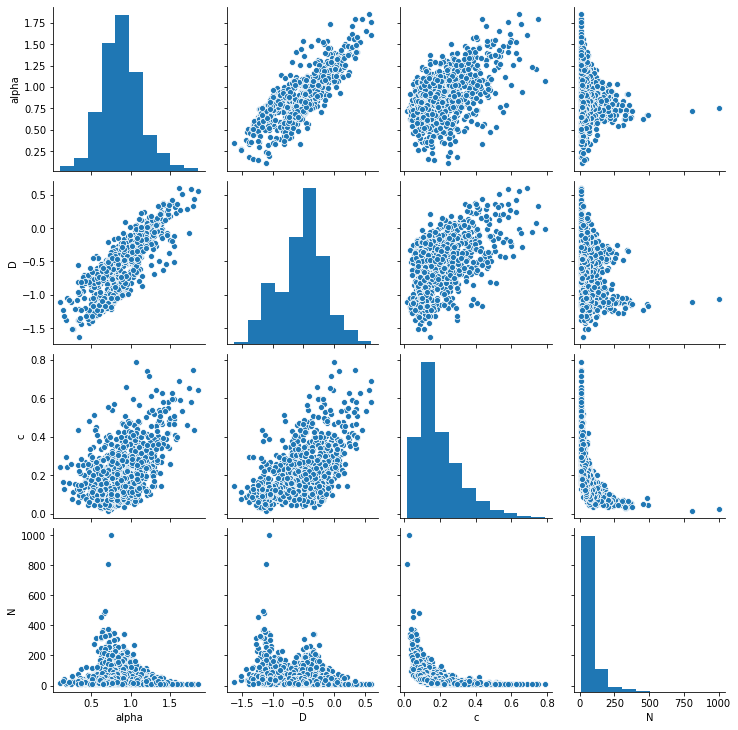

In [5]:
sns.pairplot(df[["alpha","D","c","N"]])

# CDF analysis

... and select a sample out of the available data. Notice that the two populations, can be seen in the cumulative distribution function, as two humps. 

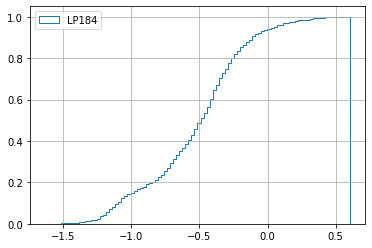

In [7]:
N = 1000
samp1 = df.sample(N)
samp1['D'].hist(bins=100,density=True, histtype='step',cumulative=True, label='LP184')
plt.legend(loc='upper left')
plt.show()

# Minframe analysis

Determining a minimum number of frames for your trajectory is a crucial step to minimize the number of false positives. But it also reduced considerably the amount of data you have at your disposal. 

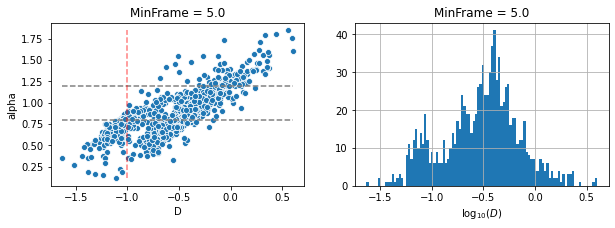

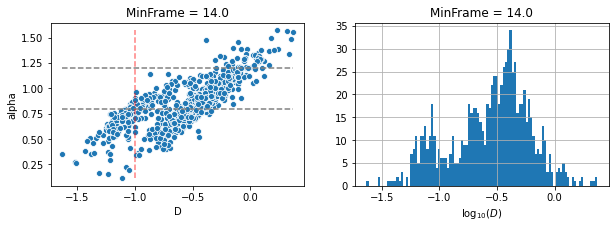

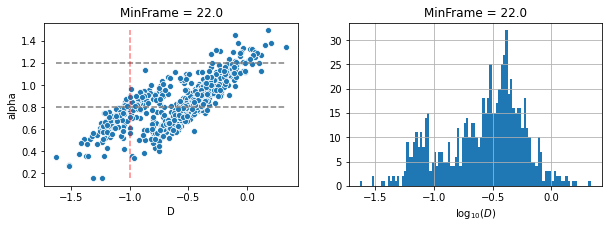

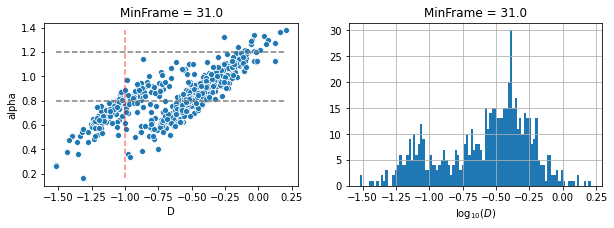

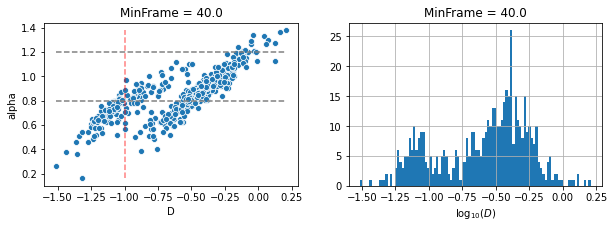

In [12]:
N = np.linspace(5,40,5)
for n in N:
    temp1 = samp1[(samp1['N']>n)]
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0])
    ax[0].hlines(0.8,min(temp1['D']),max(temp1['D']),linestyles='dashed',colors='gray')
    ax[0].hlines(1.2,min(temp1['D']),max(temp1['D']),linestyles='dashed',colors='gray')
    ax[0].vlines(-1,min(temp1['alpha']),max(temp1['alpha']),linestyles='dashed',colors='red',alpha=0.5)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    temp1['D'].hist(bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    ax[1].set_title('MinFrame = '+str(round(n)))

    plt.show()

# Classification

At this point, we can select the minimum number of frame and the minimum $R^2$ coefficient of determination for the fit of the MSDs and perform an unsupervised classification. We know the real class of each point, the first corral is at coordinates (25,25) whereas the second is at coordinates (75,75). 

In [ ]:
real_label = np.zeros(len(yarray))
yarray = list(df['y'].values)
for i in range(len(yarray)):
    y = yarray[i]
    if y[0] < 50:
        real_label[i]=0
    else:
        real_label[i]=1
df['Real_Label']=real_label

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


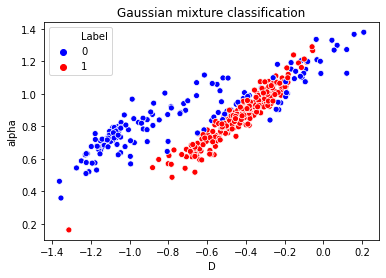

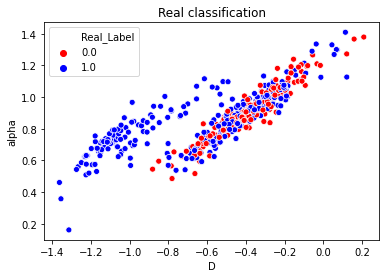

In [57]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

N = 40
R2 = 0.75

cdata1 = samp1[(samp1['N']>N) & (samp1['R2']>R2)]
temp = cdata1[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)


#Gaussian Mixture Model
gmm = GaussianMixture(n_components=2,max_iter=1000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=10)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)
colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]

cdata1['Label']=colorlist
sns.scatterplot(x='D',y='alpha',data=cdata1,hue='Label',palette=['blue','red'])
plt.title('Gaussian mixture classification')
plt.show()
sns.scatterplot(x='D',y='alpha',data=df[(df['N']>N) & (df['R2']>R2)],hue='Real_Label',palette=['red','blue'])
plt.title('Real classification')
plt.show()

# Exact $D$

As a control, we can isolate a population and compute the best estimate for the diffusion coefficient using Michalet's algorithms. For the real classification, $D_0 = 0.48$ and $D_1 = 0.29$. For the Gaussian mixture, we obtain $D_0 = 0.44$ and $D_1 = 0.26$. The results are satisfyingly close. We can get more accurate values with a larger minimum number of frames. The values we were supposed to find were $D_0 = 0.5$ and $D_1 = 0.1$. 

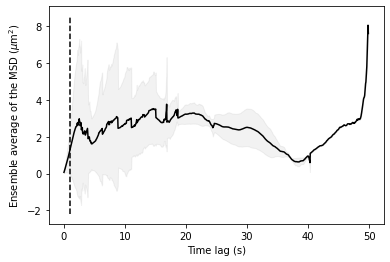

Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  2  for which the relative error sigma/b =  2.988283673510765
D =  0.2564
It is estimated that the lowest error will be when the number of fitting points P =  2  for which the relative error sigmaa/a =  0.043102502018160904
sigma =  0.0669
Second run with accurate values for D and sigma.


KeyboardInterrupt: 

In [62]:
dfilt1 = cdata1[(cdata1['Label'].isin([1]))] 
MSDSeries = dfilt1['MSD'].values
cutoff = 1
Michalet(MSDSeries,dt=dt,cutoff=cutoff)

# Exact trajectories

We can bypass the tracking section by using Smoldyn's `listmol2` function which exports to a text file the position of all the particles in the system at all desired time steps. 

In [65]:
data = pd.read_csv('Brownian_cages_2/real_coordinates.txt', sep=" ", header=None)
data.columns = ["iteration", "useless1", "useless2", "POSITION_X","POSITION_Y","TRACK_ID"]
data[["POSITION_X","POSITION_Y","TRACK_ID"]].to_csv('Brownian_cages_2/temp.csv',index=None)
files = ["Brownian_cages_2/temp.csv"]
DATA1 = data_pool(files,dt,minframe,maxframe,0,fit_option=3,display_id=True)

Track 1 out of 100
Track 2 out of 100
Track 3 out of 100
Track 4 out of 100
Track 5 out of 100
Track 6 out of 100
Track 7 out of 100
Track 8 out of 100
Track 9 out of 100
Track 10 out of 100
Track 11 out of 100
Track 12 out of 100
Track 13 out of 100
Track 14 out of 100
Track 15 out of 100
Track 16 out of 100
Track 17 out of 100
Track 18 out of 100
Track 19 out of 100
Track 20 out of 100
Track 21 out of 100
Track 22 out of 100
Track 23 out of 100
Track 24 out of 100
Track 25 out of 100
Track 26 out of 100
Track 27 out of 100
Track 28 out of 100
Track 29 out of 100
Track 30 out of 100
Track 31 out of 100
Track 32 out of 100
Track 33 out of 100
Track 34 out of 100
Track 35 out of 100
Track 36 out of 100
Track 37 out of 100
Track 38 out of 100
Track 39 out of 100
Track 40 out of 100
Track 41 out of 100
Track 42 out of 100
Track 43 out of 100
Track 44 out of 100
Track 45 out of 100
Track 46 out of 100
Track 47 out of 100
Track 48 out of 100
Track 49 out of 100
Track 50 out of 100
Track 51 

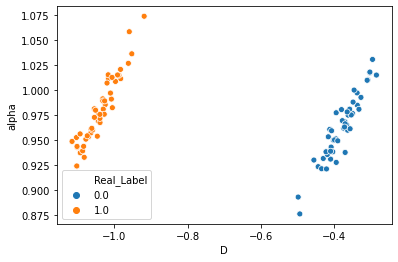

In [70]:
df_exact = pd.DataFrame(DATA1,columns=['alpha', 'D', 'c','R2','N','ID','x','y','MSD','Filename'])
df_exact['D'] = df_exact['D'].map(lambda x: np.log10(x))

yarray = list(df_exact['y'].values)
real_label = np.zeros(len(yarray))

for i in range(len(yarray)):
    y = yarray[i]
    if y[0] < 50:
        real_label[i]=0
    else:
        real_label[i]=1
        
df_exact['Real_Label']=real_label


sns.scatterplot(x='D',y='alpha',data=df_exact,hue='Real_Label')
plt.show()